## 1.Explore the YOLO model, understand how it works.

1. Divide the WxH image into  SxS grid
2. For each Grid:
    
    a. Detect B numbers of bounding box that contains an object
    
    b. Predict C condiction probability base on the trained class

Architecture of model:

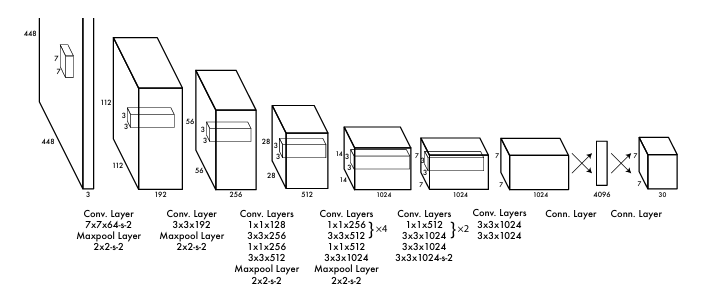

*Redmon, Joseph, Santosh Divvala, Ross Girshick, and Ali Farhadi. "You only look once: 
Unified, real-time object detection." In Proceedings of the IEEE conference on computer 
vision and pattern recognition, pp. 779-788. 2016.*

dataset:

https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/data

implmentation:

https://github.com/tanjeffreyz/yolo-v1

## 2. Define your own object detection case. Get hands-on experience by training and testing the model

Detection of construction site worker and their Personal Protective Equipment (PPE) for identification of site safety issues.

In [10]:
# Imports
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import os
import random

In [11]:
# settings
BATCH_SIZE = 64
EPOCHS = 135
WARMUP_EPOCHS = 0
LEARNING_RATE = 1E-4

EPSILON = 1E-6
IMAGE_SIZE = (448, 448)

S = 7       # Divide each image into a SxS grid
B = 2       # Number of bounding boxes to predict
C = 10      # Number of classes in the dataset

## about model
num_classes = 10

## about data
data_dir = r"./source/css-data/" ## You may need to specify the data_dir first
input_size = 448
batch_size = 64

## about training
num_epochs = 50
lr = 0.001



In [12]:
# Define the model
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = B * 5 + C

        layers = [
            # Probe(0, forward=lambda x: print('#' * 5 + ' Start ' + '#' * 5)),
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),                   # Conv 1
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('conv1', forward=probe_dist),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),                           # Conv 2
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('conv2', forward=probe_dist),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 128, kernel_size=1),                                     # Conv 3
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('conv3', forward=probe_dist),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

        for i in range(4):                                                          # Conv 4
            layers += [
                nn.Conv2d(512, 256, kernel_size=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]
        layers += [
            nn.Conv2d(512, 512, kernel_size=1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('conv4', forward=probe_dist),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

        for i in range(2):                                                          # Conv 5
            layers += [
                nn.Conv2d(1024, 512, kernel_size=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]
        layers += [
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('conv5', forward=probe_dist),
        ]

        for _ in range(2):                                                          # Conv 6
            layers += [
                nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]
        # layers.append(Probe('conv6', forward=probe_dist))

        layers += [
            nn.Flatten(),
            nn.Linear(S * S * 1024, 4096),                            # Linear 1
            nn.Dropout(),
            nn.LeakyReLU(negative_slope=0.1),
            # Probe('linear1', forward=probe_dist),
            nn.Linear(4096, S * S * self.depth),                      # Linear 2
            # Probe('linear2', forward=probe_dist),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.reshape(
            self.model.forward(x),
            (x.size(dim=0), S, S, self.depth)
        )

In [13]:
# Define the loss function

def bbox_to_coords(t):
    """Changes format of bounding boxes from [x, y, width, height] to ([x1, y1], [x2, y2])."""

    width = bbox_attr(t, 2)
    x = bbox_attr(t, 0)
    x1 = x - width / 2.0
    x2 = x + width / 2.0

    height = bbox_attr(t, 3)
    y = bbox_attr(t, 1)
    y1 = y - height / 2.0
    y2 = y + height / 2.0

    return torch.stack((x1, y1), dim=4), torch.stack((x2, y2), dim=4)

def bbox_attr(data, i):
    """Returns the Ith attribute of each bounding box in data."""

    attr_start = C + i
    return data[..., attr_start::5]


def scale_bbox_coord(coord, center, scale):
    return ((coord - center) * scale) + center

def get_iou(p, a):
    p_tl, p_br = bbox_to_coords(p)          # (batch, S, S, B, 2)
    a_tl, a_br = bbox_to_coords(a)

    # Largest top-left corner and smallest bottom-right corner give the intersection
    coords_join_size = (-1, -1, -1, B, B, 2)
    tl = torch.max(
        p_tl.unsqueeze(4).expand(coords_join_size),         # (batch, S, S, B, 1, 2) -> (batch, S, S, B, B, 2)
        a_tl.unsqueeze(3).expand(coords_join_size)          # (batch, S, S, 1, B, 2) -> (batch, S, S, B, B, 2)
    )
    br = torch.min(
        p_br.unsqueeze(4).expand(coords_join_size),
        a_br.unsqueeze(3).expand(coords_join_size)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] \
                   * intersection_sides[..., 1]       # (batch, S, S, B, B)

    p_area = bbox_attr(p, 2) * bbox_attr(p, 3)                  # (batch, S, S, B)
    p_area = p_area.unsqueeze(4).expand_as(intersection)        # (batch, S, S, B, 1) -> (batch, S, S, B, B)

    a_area = bbox_attr(a, 2) * bbox_attr(a, 3)                  # (batch, S, S, B)
    a_area = a_area.unsqueeze(3).expand_as(intersection)        # (batch, S, S, 1, B) -> (batch, S, S, B, B)

    union = p_area + a_area - intersection

    # Catch division-by-zero
    zero_unions = (union == 0.0)
    union[zero_unions] = EPSILON
    intersection[zero_unions] = 0.0

    return intersection / union

def get_dimensions(label):
    size = label['annotation']['size']
    return int(size['width']), int(size['height'])

def get_bounding_boxes(label):
    width, height = get_dimensions(label)
    x_scale = IMAGE_SIZE[0] / width
    y_scale = IMAGE_SIZE[1] / height
    boxes = []
    objects = label['annotation']['object']
    for obj in objects:
        box = obj['bndbox']
        coords = (
            int(int(box['xmin']) * x_scale),
            int(int(box['xmax']) * x_scale),
            int(int(box['ymin']) * y_scale),
            int(int(box['ymax']) * y_scale)
        )
        name = obj['name']
        boxes.append((name, coords))
    return boxes


class SumSquaredErrorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_coord = 5
        self.l_noobj = 0.5

    def forward(self, p, a):
        # Calculate IOU of each predicted bbox against the ground truth bbox
        iou = get_iou(p, a)                     # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0]     # (batch, S, S, B)

        # Get masks
        bbox_mask = bbox_attr(a, 4) > 0.0
        p_template = bbox_attr(p, 4) > 0.0
        obj_i = bbox_mask[..., 0:1]         # 1 if grid I has any object at all
        responsible = torch.zeros_like(p_template).scatter_(       # (batch, S, S, B)
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),                # (batch, S, S, B)
            value=1                         # 1 if bounding box is "responsible" for predicting the object
        )
        obj_ij = obj_i * responsible        # 1 if object exists AND bbox is responsible
        noobj_ij = ~obj_ij                  # Otherwise, confidence should be 0

        # XY position losses
        x_losses = mse_loss(
            obj_ij * bbox_attr(p, 0),
            obj_ij * bbox_attr(a, 0)
        )
        y_losses = mse_loss(
            obj_ij * bbox_attr(p, 1),
            obj_ij * bbox_attr(a, 1)
        )
        pos_losses = x_losses + y_losses
        # print('pos_losses', pos_losses.item())

        # Bbox dimension losses
        p_width = bbox_attr(p, 2)
        a_width = bbox_attr(a, 2)
        width_losses = mse_loss(
            obj_ij * torch.sign(p_width) * torch.sqrt(torch.abs(p_width) + EPSILON),
            obj_ij * torch.sqrt(a_width)
        )
        p_height = bbox_attr(p, 3)
        a_height = bbox_attr(a, 3)
        height_losses = mse_loss(
            obj_ij * torch.sign(p_height) * torch.sqrt(torch.abs(p_height) + EPSILON),
            obj_ij * torch.sqrt(a_height)
        )
        dim_losses = width_losses + height_losses
        # print('dim_losses', dim_losses.item())

        # Confidence losses (target confidence is IOU)
        obj_confidence_losses = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )
        # print('obj_confidence_losses', obj_confidence_losses.item())
        noobj_confidence_losses = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )
        # print('noobj_confidence_losses', noobj_confidence_losses.item())

        # Classification losses
        class_losses = mse_loss(
            obj_i * p[..., :C],
            obj_i * a[..., :C]
        )
        # print('class_losses', class_losses.item())

        total = self.l_coord * (pos_losses + dim_losses) \
                + obj_confidence_losses \
                + self.l_noobj * noobj_confidence_losses \
                + class_losses
        return total / BATCH_SIZE


def mse_loss(a, b):
    flattened_a = torch.flatten(a, end_dim=-2)
    flattened_b = torch.flatten(b, end_dim=-2).expand_as(flattened_a)
    return F.mse_loss(
        flattened_a,
        flattened_b,
        reduction='sum'
    )

In [14]:
# Load dataset for object detection (Roboflow YOLO labels)

from pathlib import Path
from PIL import Image
from typing import List, Dict, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class YOLODataset(Dataset):
    """
    A Dataset that reads images and Roboflow-exported YOLO label .txt files.
    Assumes directory layout:
      root_dir/
        train|valid|test/
          images/*.jpg|.png|.jpeg
          labels/*.txt  (same stem as image)

    Label file format (per line):
      <class_id> <x_center> <y_center> <width> <height>
    where all bbox coordinates are normalized to [0, 1] relative to image size.
    """

    IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

    def __init__(self, root_dir: str, split: str = "train", input_size: int = 64, transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.images_dir = self.root_dir / split / "images"
        self.labels_dir = self.root_dir / split / "labels"
        self.classes_dir = self.root_dir /  "classes.json"
        self.input_size = input_size

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform

        # Gather image files
        self.image_paths = []
        for ext in self.IMG_EXTS:
            self.image_paths.extend(sorted(self.images_dir.glob(f"*{ext}")))

        # Load class names (list of class strings)
        with open(self.classes_dir, "r") as f:
            class_list = json.load(f)
        # Map class name -> id
        self.class_to_idx = {name: idx for idx, name in enumerate(class_list)}

        if len(self.image_paths) == 0:
            raise FileNotFoundError(f"No images found in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_paths)

    def _read_labels(self, label_path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Read YOLO txt label file. Returns (labels, boxes) where:
          - labels: (N,) int64 tensor of class ids
          - boxes: (N, 4) float32 tensor of [x_center, y_center, width, height] normalized to [0,1]
        If no file or empty, returns empty tensors with right shapes.
        """
        if not label_path.exists():
            return torch.zeros((0,), dtype=torch.long), torch.zeros((0, 4), dtype=torch.float32)

        labels: List[int] = []
        boxes: List[List[float]] = []
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 5:
                    # Skip malformed lines safely
                    continue
                cls_id, x_c, y_c, w, h = parts
                try:
                    labels.append(int(float(cls_id)))
                    boxes.append([float(x_c), float(y_c), float(w), float(h)])
                except ValueError:
                    # Skip rows with invalid numbers
                    continue

        if len(labels) == 0:
            return torch.zeros((0,), dtype=torch.long), torch.zeros((0, 4), dtype=torch.float32)

        return torch.tensor(labels, dtype=torch.long), torch.tensor(boxes, dtype=torch.float32)

    def __getitem__(self, idx: int):
        img_path: Path = self.image_paths[idx]
        label_path = self.labels_dir / (img_path.stem + ".txt")

        # Load image
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = self.transform(img)

        # Load labels (normalized YOLO format)
        labels, coords = self._read_labels(label_path)

        # Build target dictionary (kept for potential future use)
        target: Dict[str, torch.Tensor] = {
            "labels": labels,          # (N,)
            "boxes_yolo": coords,       # (N, 4) normalized [x_c, y_c, w, h]
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "orig_path": str(img_path),
        }

        # Build YOLOv1-style ground truth tensor of shape (S, S, 5*B + C)
        original_data = img
        width = original_data.size(dim=2)
        height = original_data.size(dim=1)
        grid_size_x = width / S   # (W / S)
        grid_size_y = height / S  # (H / S)

        boxes_count_in_cell: Dict[Tuple[int, int], int] = {}
        depth = 5 * B + C
        ground_truth = torch.zeros((S, S, depth), dtype=torch.float32)

        # Iterate all labeled boxes for this image
        # coords are normalized to [0,1]: (xc, yc, w, h)
        for class_idx, (xc, yc, bw, bh) in zip(labels.tolist(), coords.tolist()):
            # Convert center to pixel coords to choose the grid cell, but keep normalized values in tensor
            mid_x = xc * width
            mid_y = yc * height
            col = int(mid_x // grid_size_x)
            row = int(mid_y // grid_size_y)

            if 0 <= col < S and 0 <= row < S:
                cell = (row, col)

                # Class one-hot for this cell
                one_hot = torch.zeros(C, dtype=torch.float32)
                if 0 <= class_idx < C:
                    one_hot[class_idx] = 1.0
                ground_truth[row, col, :C] = one_hot

                # Which bbox slot to use in this cell
                bbox_index = boxes_count_in_cell.get(cell, 0)
                if bbox_index < B:
                    # Store bbox as normalized image coords (xc, yc, w, h) and confidence 1.0
                    # Keep xc, yc, w, h in [0,1] to be consistent and avoid negatives
                    bbox_truth = torch.tensor((xc, yc, bw, bh, 1.0), dtype=torch.float32)
                    start = C + bbox_index * 5
                    end = start + 5
                    ground_truth[row, col, start:end] = bbox_truth
                    boxes_count_in_cell[cell] = bbox_index + 1

        # Return image and dense ground-truth tensor
        return img, ground_truth, original_data


def detection_collate_fn(batch):
    """Custom collate to handle variable number of boxes per image."""
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return torch.stack(images, dim=0), torch.stack(targets, dim=0)


def load_yolo_data(data_dir: str = "./data/", input_size: int = 448, batch_size: int = 16):
    """
    Create DataLoaders for object detection using Roboflow YOLO labels.
    Expects the following structure under data_dir:
      data_dir/
        train/ images/, labels/
        valid/ images/, labels/
        test/  images/, labels/    (optional)
    """
    train_ds = YOLODataset(data_dir, split="train", input_size=input_size)
    valid_split = "valid" if (Path(data_dir) / "valid").exists() else "test"
    valid_ds = YOLODataset(data_dir, split=valid_split, input_size=input_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=detection_collate_fn)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=detection_collate_fn)

    return train_loader, valid_loader

In [15]:
## Note that: here we provide a basic solution for training and validation.
## You can directly change it if you find something wrong or not good enough.

def train_model(model,train_loader, valid_loader, criterion, optimizer, device, num_epochs=20):        
    """
    Train the YOLOv1-style detector with SumSquaredErrorLoss.
    - Computes a simple proxy metric: per-cell class accuracy on cells that contain objects.
    - Adds NaN guards to avoid corrupting weights if the loss becomes invalid.
    """
    best_acc = 0.0

    def cell_class_accuracy(outputs, labels_tensor):
        # outputs, labels: (B, S, S, C + 5*B)
        # consider only class channels for cells with objects (confidence in first bbox > 0)
        class_logits = outputs[..., :C]
        gt_onehot = labels_tensor[..., :C]
        # object mask from first bbox confidence
        obj_mask = labels_tensor[..., C + 4] > 0  # confidence at first bbox slot
        if obj_mask.sum().item() == 0:
            return 0.0
        pred_cls = class_logits.argmax(dim=-1)
        gt_cls = gt_onehot.argmax(dim=-1)
        correct = ((pred_cls == gt_cls) & obj_mask).sum().item()
        total = obj_mask.sum().item()
        return correct / max(total, 1)

    for epoch in range(num_epochs):
        # train the model
        model.train(True)
        total_loss = 0.0
        running_acc = 0.0
        batches = 0
        for inputs, labels in train_loader:
            # send the data to device (GPU)
            inputs = inputs.to(device)
            labels_tensor = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # prediction

            # NaN guard on outputs
            if torch.isnan(outputs).any():
                print('[warn] NaN detected in outputs; skipping batch')
                continue

            loss = criterion(outputs, labels_tensor) # loss
            # NaN guard on loss
            if torch.isnan(loss) or torch.isinf(loss):
                print('[warn] Invalid loss (NaN/Inf); skipping batch')
                continue

            loss.backward()
            # optional: clip to avoid exploding grads
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            running_acc += cell_class_accuracy(outputs.detach(), labels_tensor)
            batches += 1
        train_loss = total_loss / max(len(train_loader.dataset), 1)
        train_acc = (running_acc / max(batches, 1))
        
        # validation
        model.train(False)
        total_loss = 0.0
        running_acc = 0.0
        batches = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels_tensor = labels.to(device)
                outputs = model(inputs)
                if torch.isnan(outputs).any():
                    print('[warn] NaN detected in val outputs; skipping batch')
                    continue
                loss = criterion(outputs, labels_tensor)
                if torch.isnan(loss) or torch.isinf(loss):
                    print('[warn] Invalid val loss (NaN/Inf); skipping batch')
                    continue
                total_loss += loss.item() * inputs.size(0)
                running_acc += cell_class_accuracy(outputs, labels_tensor)
                batches += 1
        valid_loss = total_loss / max(len(valid_loader.dataset), 1)
        valid_acc = (running_acc / max(batches, 1))
        
        # Show the results
        print('*' * 100)
        print('epoch:{:d}/{:d}'.format(epoch, num_epochs))
        print("training: loss:   {:.6f}, cell-acc(obj): {:.4f}".format(train_loss, train_acc))
        print("validation: loss: {:.6f}, cell-acc(obj): {:.4f}".format(valid_loss, valid_acc))
        
        # save the best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

In [16]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_random_from_loader(loader, class_names=None):
    """
    Visualize a random image from the detection DataLoader built by `load_yolo_data`.

    Expects batches like:
      imgs:    (B, 3, H, W)
      targets: (B, S, S, C + 5*B) where for each cell and for each bbox slot k:
                [xc, yc, w, h, conf] are normalized to [0,1] over the full image
                and classes are one-hot in the first C channels.

    Draws all GT boxes (cells whose conf > 0 in any bbox slot) on the image and
    annotates with the cell's class if provided.
    """
    imgs, targets = next(iter(loader))
    b = imgs.shape[0]
    if b == 0:
        print('Empty batch from loader; nothing to visualize.')
        return

    idx = random.randrange(b)
    img = imgs[idx]
    gt = targets[idx]  # (S, S, C + 5*B)

    H, W = img.shape[1], img.shape[2]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img.permute(1, 2, 0).numpy())

    any_box = False
    for row in range(S):
        for col in range(S):
            # Determine class for this cell (if any)
            cell_classes = gt[row, col, :C]
            cls_id = int(cell_classes.argmax().item()) if cell_classes.max().item() > 0 else None

            # Iterate over B bbox slots
            for k in range(B):
                start = C + k * 5
                xc = float(gt[row, col, start + 0].item())
                yc = float(gt[row, col, start + 1].item())
                w  = float(gt[row, col, start + 2].item())
                h  = float(gt[row, col, start + 3].item())
                conf = float(gt[row, col, start + 4].item())

                if conf <= 0:
                    continue

                any_box = True
                x1 = (xc - w / 2.0) * W
                y1 = (yc - h / 2.0) * H
                rect = patches.Rectangle((x1, y1), w * W, h * H, linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)

                if cls_id is not None:
                    label_txt = class_names[cls_id] if class_names and 0 <= cls_id < len(class_names) else f"cls {cls_id}"
                    ax.text(x1, max(0, y1 - 3), label_txt, color='yellow', fontsize=10,
                            bbox=dict(facecolor='black', alpha=0.5, pad=1))

    if not any_box:
        ax.text(5, 15, "No GT boxes in sample", color='red', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, pad=2))

    ax.axis('off')
    plt.show()


## Below start to run functions

device: cuda


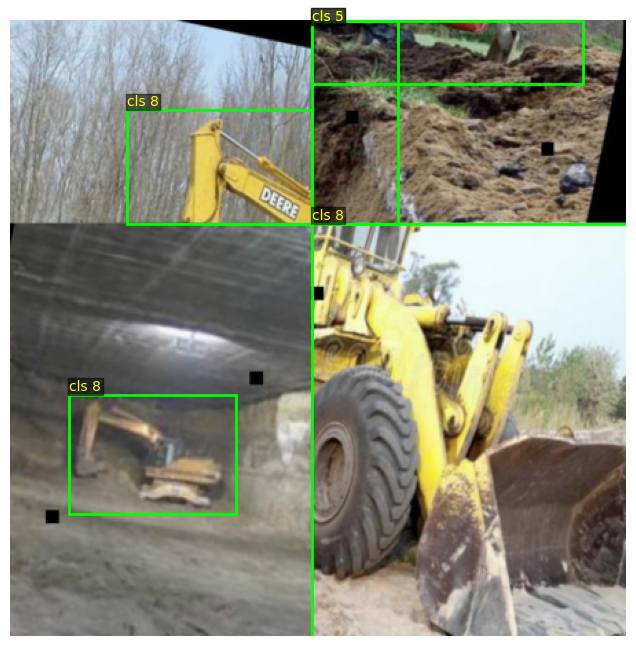

In [17]:
## model initialization
model = YOLOv1()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)
model = model.to(device)

## optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
## loss function
criterion = SumSquaredErrorLoss()

## detection data preparation for visualization only
yolo_train_loader, yolo_valid_loader = load_yolo_data(data_dir=data_dir, input_size=input_size, batch_size=8)
visualize_random_from_loader(yolo_train_loader)


In [21]:

train_model(model, yolo_train_loader, yolo_valid_loader, criterion, optimizer, device, num_epochs=num_epochs)

****************************************************************************************************
epoch:0/50
training: loss:   2.076658, cell-acc(obj): 0.3229
validation: loss: 1.386795, cell-acc(obj): 0.2710
****************************************************************************************************
epoch:1/50
training: loss:   2.037456, cell-acc(obj): 0.3275
validation: loss: 1.396739, cell-acc(obj): 0.2693
****************************************************************************************************
epoch:2/50
training: loss:   2.024339, cell-acc(obj): 0.3297
validation: loss: 1.383372, cell-acc(obj): 0.2646
****************************************************************************************************
epoch:3/50
training: loss:   2.018306, cell-acc(obj): 0.3309
validation: loss: 1.376610, cell-acc(obj): 0.2646
****************************************************************************************************
epoch:4/50
training: loss:   2.013857, cell-acc(obj

KeyboardInterrupt: 

Loaded best model from best_model.pt


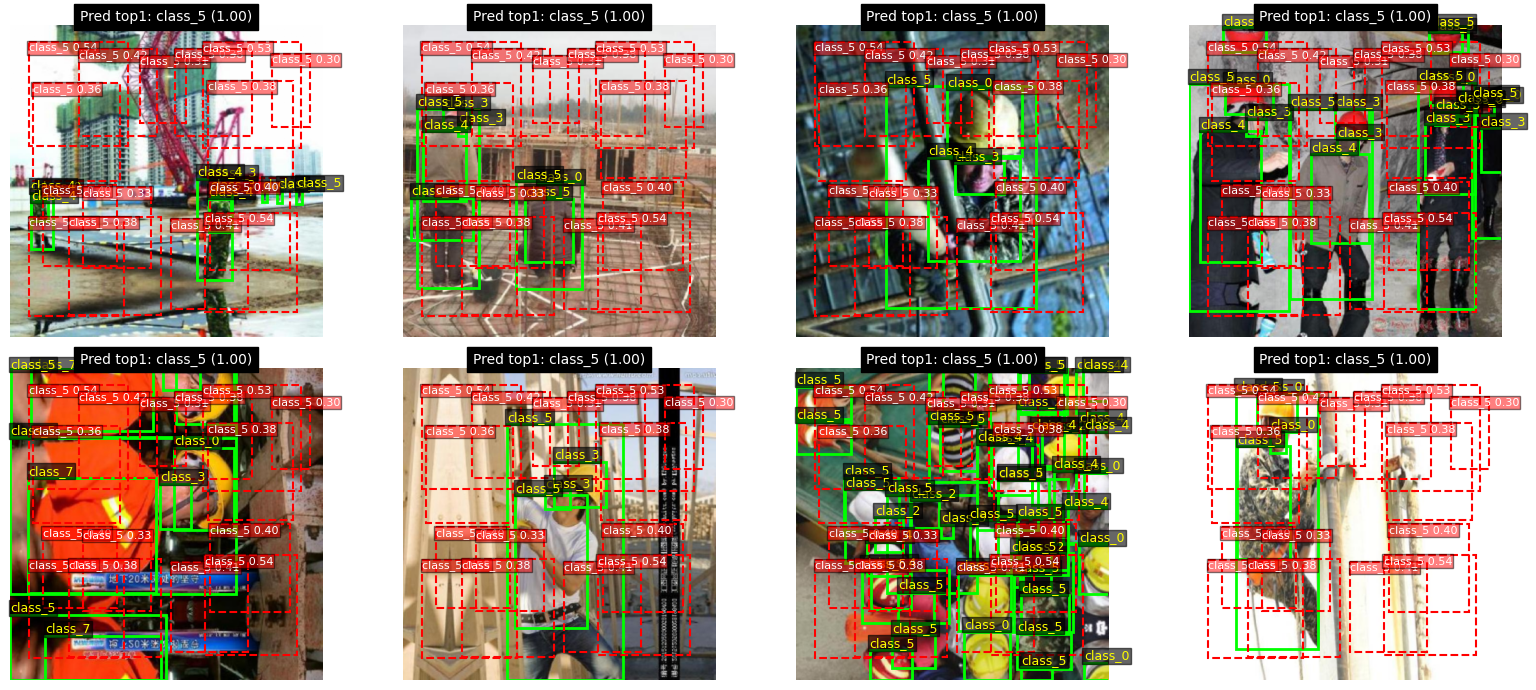

In [20]:
# Visualize validation results
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_validation_results(model, valid_loader, class_names=None, device=None, n_images=8, conf_thresh=0.3):
    """
    Visualize validation samples for the YOLOv1-style model with new loader outputs.

    Inputs:
      - model: produces outputs of shape (B, S, S, C + 5*B)
      - valid_loader: yields (imgs, targets) where
            imgs:    (B, 3, H, W)
            targets: (B, S, S, C + 5*B)
      - class_names: list of length C (optional)
      - device: torch device
      - n_images: number of images to preview from the batch
      - conf_thresh: threshold to draw predicted boxes for any bbox slot

    Drawing:
      - Green boxes: Ground-truth from targets (confidence > 0)
      - Red boxes: Predictions from model (confidence >= conf_thresh)
      - Title: Top-1 predicted class for the image (derived by summing per-cell class logits)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()

    # Get a single batch
    imgs, targets = next(iter(valid_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        outputs = model(imgs)  # (B, S, S, C + 5*B)

    # Move to CPU for plotting
    imgs_cpu = imgs.cpu()
    targets_cpu = targets.cpu()
    outputs_cpu = outputs.cpu()

    batch_size = imgs_cpu.shape[0]
    n_show = int(min(n_images, batch_size))

    fig_cols = 4
    fig_rows = int(np.ceil(n_show / fig_cols))
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(4 * fig_cols, 3.5 * fig_rows))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Helper to safely clamp to [0,1]
    def clamp01(x):
        return max(0.0, min(1.0, float(x)))

    # Title prediction: aggregate class logits over all cells
    def image_top1_class(pred):
        # pred: (S, S, C + 5*B)
        class_logits = pred[..., :C]  # (S,S,C)
        summed = class_logits.sum(dim=(0, 1))  # (C,)
        return int(torch.argmax(summed).item()), float(torch.softmax(summed, dim=0).max().item())

    for i in range(n_show):
        ax = axes[i]
        img = imgs_cpu[i].permute(1, 2, 0).numpy()
        H, W = img.shape[:2]
        gt = targets_cpu[i]       # (S,S,C+5B)
        pred = outputs_cpu[i]     # (S,S,C+5B)

        ax.imshow(img)
        ax.axis('off')

        # Title from aggregated class prediction
        top_cls, top_score = image_top1_class(pred)
        ptxt = (class_names[top_cls] if class_names and 0 <= top_cls < len(class_names) else f'class {top_cls}')
        ax.set_title(f'Pred top1: {ptxt} ({top_score:.2f})', color='white', fontsize=10, pad=3,
                     backgroundcolor='black')

        # Draw GT boxes (green)
        any_gt = False
        for row in range(S):
            for col in range(S):
                # cell class (for label)
                cell_classes = gt[row, col, :C]
                gt_cls = int(cell_classes.argmax().item()) if cell_classes.max().item() > 0 else None
                # boxes
                for k in range(B):
                    s = C + 5 * k
                    gxc, gyc, gw, gh, gconf = [float(gt[row, col, s + t].item()) for t in range(5)]
                    if gconf <= 0:
                        continue
                    any_gt = True
                    x1 = (gxc - gw / 2.0) * W
                    y1 = (gyc - gh / 2.0) * H
                    rect = patches.Rectangle((x1, y1), gw * W, gh * H, linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
                    if gt_cls is not None:
                        gtxt = class_names[gt_cls] if class_names and 0 <= gt_cls < len(class_names) else f'gt {gt_cls}'
                        ax.text(x1, max(0, y1 - 5), gtxt, color='yellow', fontsize=9,
                                bbox=dict(facecolor='black', alpha=0.6, pad=1))

        # Draw predicted boxes (red) for slots with confidence >= threshold
        any_pred = False
        for row in range(S):
            for col in range(S):
                # Predicted class per cell (for label)
                cell_logits = pred[row, col, :C]
                p_cls = int(torch.argmax(cell_logits).item())
                # For each bbox slot
                for k in range(B):
                    s = C + 5 * k
                    pxc = clamp01(pred[row, col, s + 0].item())
                    pyc = clamp01(pred[row, col, s + 1].item())
                    pw  = clamp01(abs(pred[row, col, s + 2].item()))
                    ph  = clamp01(abs(pred[row, col, s + 3].item()))
                    pconf = float(pred[row, col, s + 4].item())
                    if pconf < conf_thresh:
                        continue
                    any_pred = True
                    x1 = (pxc - pw / 2.0) * W
                    y1 = (pyc - ph / 2.0) * H
                    rect = patches.Rectangle((x1, y1), pw * W, ph * H, linewidth=1.5, edgecolor='red', facecolor='none', linestyle='--')
                    ax.add_patch(rect)
                    ptxt = class_names[p_cls] if class_names and 0 <= p_cls < len(class_names) else f'pred {p_cls}'
                    ax.text(x1, min(H - 2, y1 + 12), f'{ptxt} {pconf:.2f}', color='white', fontsize=8,
                            bbox=dict(facecolor='red', alpha=0.5, pad=1))

        if not any_gt and not any_pred:
            ax.text(5, 15, 'No GT/Pred boxes', color='white', fontsize=10,
                    bbox=dict(facecolor='black', alpha=0.6, pad=1))

    # Hide unused axes
    for k in range(n_show, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


# Load best model if available; else use current `model`
model_to_eval = model
best_model_path = 'best_model.pt'
if os.path.exists(best_model_path):
    try:
        model_to_eval = torch.load(best_model_path, map_location=device, weights_only=False)
        model_to_eval = model_to_eval.to(device)
        print('Loaded best model from', best_model_path)
    except Exception as e:
        print('Could not load best model, using current model. Reason:', e)


# Visualize a few validation samples
visualize_validation_results(model_to_eval, yolo_valid_loader, class_names=class_names, device=device, n_images=8, conf_thresh=0.3)